# 🔭 Using the GaiaUnlimited precomputed APOGEE selection function

The APOGEE selection function depends on the apparent magnitude of the source in the $H$ band, on its intrinsic colour (because the APOGEE target selection is performed on de-reddened photometry) and on the location on the sky.

The ``gaiaunlimited`` package provides the function ``gaiaunlimited.apogee_sf`` which takes three arguments: the apparent magnitude $H$, the intrinsic colour $(J-K)_0$, and the location on the sky (as an ``astropy`` coordinate object).

In [1]:
import gaiaunlimited
from gaiaunlimited import utils 
import numpy as np
import matplotlib.pyplot as plt

For this example I map the entire sky in healpix regions of order 7 to make the end figure looks nicer. It takes several minutes to complete. Using ``healpix_order=4`` only takes a few seconds.

In [2]:
%%time

healpix_order = 7

H_to_query = 10.5
JK0_to_query = 0.6

# Grab the coordinates of the centres of healpix regions:
coords_of_centers = utils.get_healpix_centers(healpix_order)
NNN = len( coords_of_centers )

# Query the precomputed selection at those locations:
sel_frac_apogee = gaiaunlimited.apogee_sf(H_to_query*np.ones(NNN),JK0_to_query*np.ones(NNN),coords_of_centers)
sel_frac_apogee = np.array(sel_frac_apogee)
sel_frac_apogee[ sel_frac_apogee==0 ] = np.nan

CPU times: user 7min 13s, sys: 800 ms, total: 7min 13s
Wall time: 7min 15s


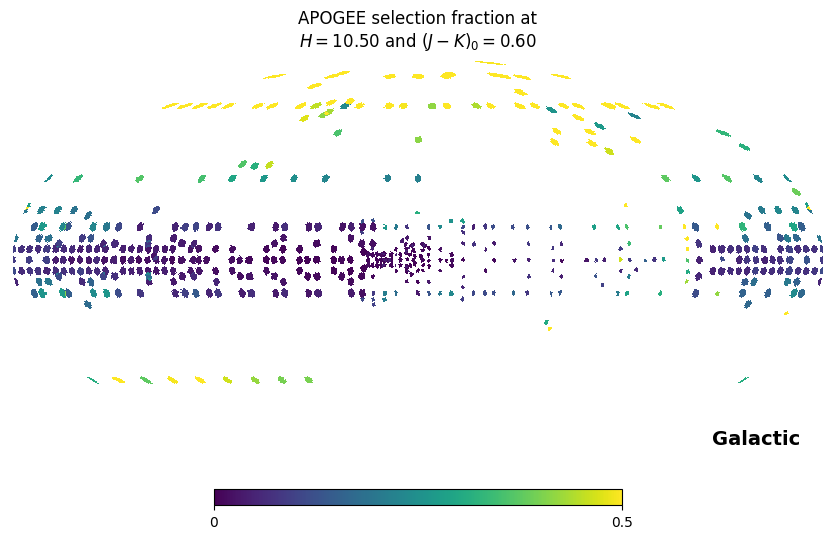

In [3]:
import healpy as hp
hp.mollview( sel_frac_apogee , nest=False , coord = 'CG' , min=0 , max=0.5,
            title='APOGEE selection fraction at\n$H=%.2f$ and $(J-K)_0=%.2f$' % (H_to_query,JK0_to_query),badcolor='white')
plt.show()

## How we constructed the APOGEE selection function

The method we followed to obtain the APOGEE selection function was introduced in [Bovy et al. (2014)](https://ui.adsabs.harvard.edu/abs/2014ApJ...790..127B) (see also [Bovy et al. (2016)](https://ui.adsabs.harvard.edu/abs/2016ApJ...823...30B) and [Frankel et al. (2019)](https://ui.adsabs.harvard.edu/abs/2019ApJ...884...99F)).

The idea is: in each field observed by APOGEE, count the number of 2MASS targets in bins of $H$ and $(J-K)_0$, then count which fraction of them have corresponding APOGEE data.

In [4]:
from astropy.table import Table
import matplotlib.pyplot as plt
import numpy as np

## Read the table containing stellar parameters for APOGEE DR17

For this to work you need to download the `allStarLite` table locally, the file is about 1.8 GB:
https://www.sdss4.org/dr17/irspec/spectro_data/

In [5]:
from astropy.table import Table
tAllstars = Table.read('/Users/cantat/gaiaunlimited/apogee/allStarLite-dr17-synspec_rev1.fits')

Text(0.5, 1.0, 'location of all 733901 APOGEE DR17 stars')

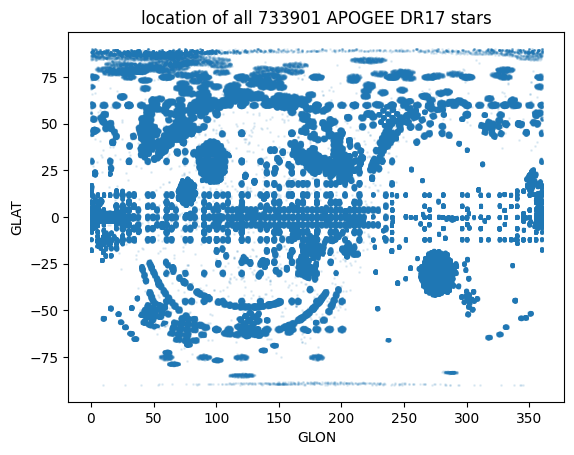

In [6]:
plt.scatter( tAllstars['GLON'] , tAllstars['GLAT'] , s=1 , alpha=0.1 )
plt.xlabel('GLON')
plt.ylabel('GLAT')
plt.title('location of all %i APOGEE DR17 stars' % (len(tAllstars)))

In [7]:
%%time
fieldsWeWant = []
for i in range(len(tAllstars)):
    if tAllstars['PROGRAMNAME'][i] in ['bulge','disk','disk1','disk2','apogee']:
        try:
            a = int(tAllstars['FIELD'][i].split('+')[0])
            b = int(tAllstars['FIELD'][i].split('+')[1])
            c = a+b
            fieldsWeWant.append( tAllstars['FIELD'][i] )
        except:
            try:
                a = int(tAllstars['FIELD'][i].split('-')[0])
                b = int(tAllstars['FIELD'][i].split('-')[1])
                c = a+b
                fieldsWeWant.append( tAllstars['FIELD'][i] )
            except:
                pass
        

fieldsWeWant = sorted(set(fieldsWeWant))
print('We have retained %i fields.' % (len(fieldsWeWant)))

We have retained 566 fields.
CPU times: user 10.7 s, sys: 29.1 ms, total: 10.8 s
Wall time: 10.8 s


We only stars that belong to grid pointings. They have:

* a PROGRAMNAME = 'bulge', or 'disk', or 'disk1', or 'disk2', or 'apogee'

* a FIELD name indicating it is a grid pointing, i.e. "LLL+BB" or "LLL-BB"

## Read the table describing the design of all APOGEE and APOGEE-2 pointings

This table is a much smaller file than the entire APOGEE DR17 data, so we read it directly from the website:

Text(0.5, 1.0, 'location of all 4149 APOGEE designs')

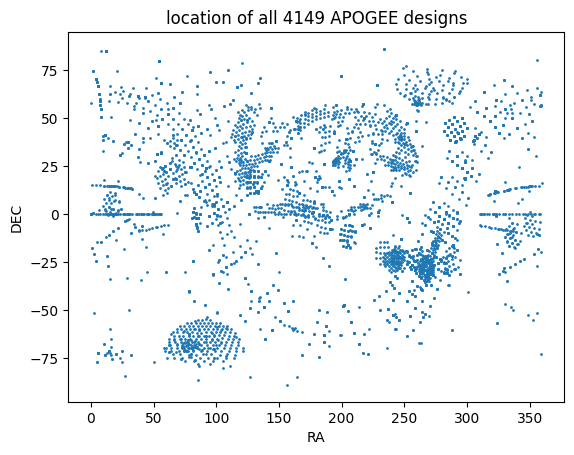

In [8]:
target_url = 'https://data.sdss.org/sas/dr17/apogee/target/allDesign.fits'
tDesigns = Table.read(target_url)

plt.scatter( tDesigns['RA'] , tDesigns['DEC'] , s=1  )
plt.xlabel('RA')
plt.ylabel('DEC')
plt.title('location of all %i APOGEE designs' % (len(tDesigns)))

If a given field was targeted with more than one design, verify that the design was the same every time, or else the selection function is not tractable. The values of:

* COHORT_MIN_H
* COHORT_MAX_H
* BIN_DEREDDENED_MIN_JK_COLOR
* BIN_DEREDDENED_MAX_JK_COLOR
* RADIUS
* LOCATION_ID

must remain unchanged for repeated designs of a given field.

We found 71 fields with inconsistent designs.
495 of our fields have consistent designs and therefore a tractable selection function.


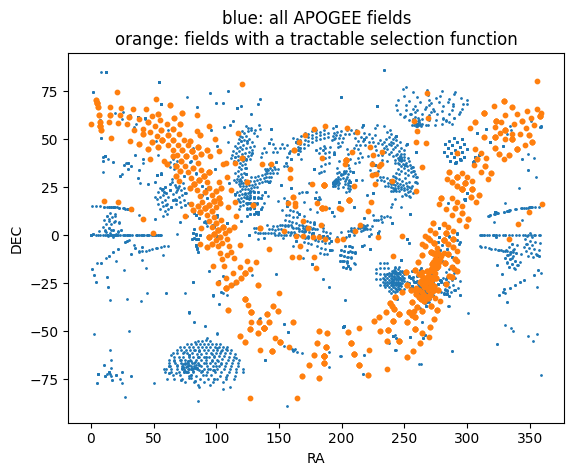

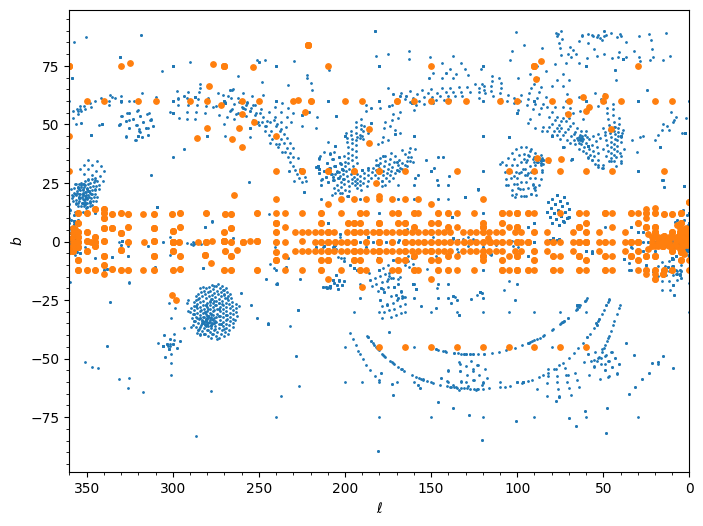

In [9]:
#remove trailing spaces in field names:
designFieldNames = np.array([n.strip() for n in tDesigns['FIELD_NAME']])

inconsistentField = [] #for all fields with inconistent designs

for j,f in enumerate(fieldsWeWant):
    reduced_tDesigns = tDesigns['COHORT_MIN_H','COHORT_MAX_H','BIN_DEREDDENED_MIN_JK_COLOR','BIN_DEREDDENED_MAX_JK_COLOR','RADIUS','LOCATION_ID']
    reduced_tDesigns = reduced_tDesigns[  designFieldNames == f ]
    
    #if more than one row in reduced_t, check that they are all the same:
    if len(reduced_tDesigns)>1:
        for ii in range(len(reduced_tDesigns)):
            if reduced_tDesigns[0]['RADIUS'] != reduced_tDesigns[ii]['RADIUS']:
                #print(f,reduced_tDesigns)
                inconsistentField.append(f)
                break
            if reduced_tDesigns[0]['LOCATION_ID'] != reduced_tDesigns[ii]['LOCATION_ID']:
                #print(f,reduced_tDesigns)
                inconsistentField.append(f)
                break
            if np.any( ~(reduced_tDesigns[0]['BIN_DEREDDENED_MIN_JK_COLOR'] == reduced_tDesigns[ii]['BIN_DEREDDENED_MIN_JK_COLOR']) ):
                #print(f,reduced_tDesigns)
                inconsistentField.append(f)
                break
            if np.any( ~(reduced_tDesigns[0]['BIN_DEREDDENED_MAX_JK_COLOR'] == reduced_tDesigns[ii]['BIN_DEREDDENED_MAX_JK_COLOR']) ):
                #print(f,reduced_tDesigns)
                inconsistentField.append(f)
                break
            if np.any( ~(reduced_tDesigns[0]['COHORT_MIN_H'] == reduced_tDesigns[ii]['COHORT_MIN_H']) ):
                #print(f,reduced_tDesigns)
                inconsistentField.append(f)
                break
            if np.any( ~(reduced_tDesigns[0]['COHORT_MAX_H'] == reduced_tDesigns[ii]['COHORT_MAX_H']) ):
                #print(f,reduced_tDesigns)
                inconsistentField.append(f)
                break
                
# In these two fields I manually found that the inconsistency has no consequence because it concerns empty cohorts:
inconsistentField.remove('165+00')
inconsistentField.remove('195+00')

# I also realised later that three consistent fields contain only EXTRATARG>0 targets:
inconsistentField.append('024+00')
inconsistentField.append('027+04')
inconsistentField.append('027-04')

print('We found %i fields with inconsistent designs.' % (len(inconsistentField)) )
consistentField = [f for f in fieldsWeWant if (f in inconsistentField)==False ]
print(('%i of our fields have consistent designs and therefore a tractable selection function.') % (len(consistentField)))

isConsistent = np.array([f in consistentField for f in designFieldNames])
plt.scatter( tDesigns['RA'] , tDesigns['DEC'] , s=1  )
plt.scatter( tDesigns['RA'][isConsistent] , tDesigns['DEC'][isConsistent] , s=10  )
plt.xlabel('RA')
plt.ylabel('DEC')
plt.title('blue: all APOGEE fields\norange: fields with a tractable selection function')


from astropy.coordinates import SkyCoord
coords = SkyCoord( tDesigns['RA'] , tDesigns['DEC'] , unit='deg')


plt.figure(figsize=(8,6))
plt.scatter( coords.galactic.l , coords.galactic.b , s=1  )
plt.scatter( coords.galactic.l.value[isConsistent] , coords.galactic.b.value[isConsistent] , s=15  )
plt.xlabel('$\ell$')
plt.ylabel('$b$')
plt.xlim(360,0)
plt.minorticks_on()

## The selection function inside each field

The full list of 2MASS targets inside each field is available in the following directories:

https://data.sdss.org/sas/dr17/apogee/target/apogeeObject/

https://data.sdss.org/sas/dr17/apogee/target/apogee2Object/

The binning in colour and magnitude used for target selection is given in the allDesign table:

https://data.sdss.org/sas/dr17/apogee/target/allDesign.fits

The list of targets with succesful observations is available at:

https://data.sdss.org/sas/dr17/apogee/spectro/aspcap/dr17/synspec_rev1/allStar-dr17-synspec_rev1.fits

For each field we will:

1. read the entire list of available 2MASS targets

2. read the design from the allDesign table

3. compare the number of available sources in each bin to the number of sources actually observed

The Main Red Star Sample can be conveniently identified using the EXTRATARG bitmask in the allStar file. If no bits are set in EXTRATARG (i.e., **EXTRATARG==0**), that target meets the criteria for the Main Red Star Sample for its sky location (disk, bulge, or halo).



In [10]:
# only keep the main red star sample:
tAllstars = tAllstars[   tAllstars['EXTRATARG']==0 ]
# with succesful observations:
hasValidRV = np.array([True if foo>-1000 else False for foo in tAllstars['VHELIO_AVG'] ])
tAllstars = tAllstars[hasValidRV]
#remove trailing spaces in their field names:
observedNames = np.array([n.strip() for n in tAllstars['FIELD']])

This downloads the 2MASS data directly from the SDSS page. For field `034-06` the file is about 200 MB.

In [11]:
%%time
example_field = '034-06'
tField = Table.read('https://data.sdss.org/sas/dr17/apogee/target/apogee2Object/apogee2Object_%s.fits' % (example_field))

CPU times: user 950 ms, sys: 840 ms, total: 1.79 s
Wall time: 43.4 s


The H and (J-K)_0 bins used to select targets in this field are:

COHORT_MIN_H [10.0 12.199999809265137 12.800000190734863]
COHORT_MAX_H [12.199999809265137 12.800000190734863 13.300000190734863]
BIN_DEREDDENED_MIN_JK_COLOR [0.5 0.800000011920929 999.0 999.0 999.0]
BIN_DEREDDENED_MAX_JK_COLOR [8.00e-01 9.99e+02 9.99e+02 9.99e+02 9.99e+02]


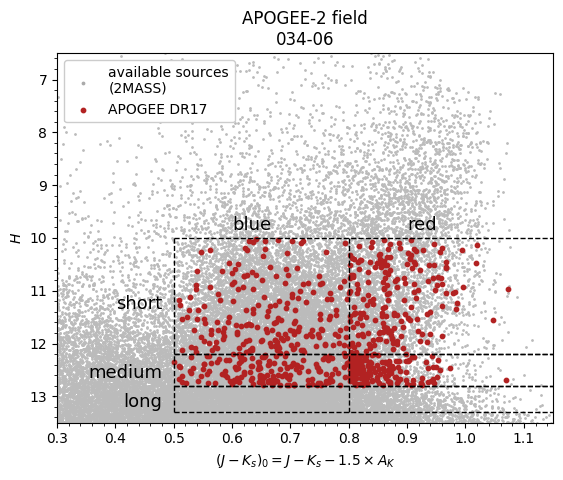

In [12]:
thisDesign = tDesigns[ designFieldNames == example_field ][0]
print('The H and (J-K)_0 bins used to select targets in this field are:\n')
print( 'COHORT_MIN_H', thisDesign['COHORT_MIN_H'] )
print( 'COHORT_MAX_H', thisDesign['COHORT_MAX_H'] )
print( 'BIN_DEREDDENED_MIN_JK_COLOR', thisDesign['BIN_DEREDDENED_MIN_JK_COLOR'] )
print( 'BIN_DEREDDENED_MAX_JK_COLOR', thisDesign['BIN_DEREDDENED_MAX_JK_COLOR'] )

deReddenedJK = tField['J'] - tField['K'] - 1.5000 * tField['AK_TARG']
obs_JK = tAllstars['J'][ observedNames == example_field ] - tAllstars['K'][ observedNames == example_field ]
obs_deReddenedJK = obs_JK - 1.5000 * tAllstars['AK_TARG'][ observedNames == example_field ]
obsH = tAllstars['H'][ observedNames == example_field ]



plt.figure()

plt.title('APOGEE-2 field\n%s' % (example_field))

plt.scatter( deReddenedJK , tField['H'] , s=1 , c='#bbbbbb', rasterized=True)
plt.scatter( -1 , -1 , s=3 , c='#aaaaaa' ,label='available sources\n(2MASS)')
plt.scatter( obs_deReddenedJK , obsH , c='firebrick', s=10 , label='APOGEE DR17')

# limits:
plt.xlim( 0.3 , 1.15 )     
plt.ylim( 13.5 , 6.5 )
# add design grid:
plt.plot( [0.5 , max(obs_deReddenedJK) + 0.1] , [thisDesign['COHORT_MIN_H'][0],thisDesign['COHORT_MIN_H'][0]] ,
         'k--',lw=1)
plt.plot( [0.5 , max(obs_deReddenedJK) + 0.1] , [thisDesign['COHORT_MAX_H'][0],thisDesign['COHORT_MAX_H'][0]] ,
         'k--',lw=1)
#
plt.plot( [0.5 , max(obs_deReddenedJK) + 0.1] , [thisDesign['COHORT_MIN_H'][1],thisDesign['COHORT_MIN_H'][1]] ,
         'k--',lw=1)
plt.plot( [0.5 , max(obs_deReddenedJK) + 0.1] , [thisDesign['COHORT_MAX_H'][1],thisDesign['COHORT_MAX_H'][1]] ,
         'k--',lw=1)
#
plt.plot( [0.5 , max(obs_deReddenedJK) + 0.1] , [thisDesign['COHORT_MIN_H'][2],thisDesign['COHORT_MIN_H'][2]] ,
         'k--',lw=1)
plt.plot( [0.5 , max(obs_deReddenedJK) + 0.1] , [thisDesign['COHORT_MAX_H'][2],thisDesign['COHORT_MAX_H'][2]] ,
         'k--',lw=1)
# and colour bin:
plt.plot( [thisDesign['BIN_DEREDDENED_MIN_JK_COLOR'][0],thisDesign['BIN_DEREDDENED_MIN_JK_COLOR'][0]] ,
         [min(thisDesign['COHORT_MIN_H']),max(thisDesign['COHORT_MAX_H'])] , 'k--',lw=1)
plt.plot( [thisDesign['BIN_DEREDDENED_MIN_JK_COLOR'][1],thisDesign['BIN_DEREDDENED_MIN_JK_COLOR'][1]] ,
         [min(thisDesign['COHORT_MIN_H']),max(thisDesign['COHORT_MAX_H'])] , 'k--',lw=1)
#
plt.xlabel('$(J-K_s)_0 = J - K_s - 1.5 \\times A_K$')
plt.ylabel('$H$')
plt.minorticks_on()

plt.text(0.48,13.2,'long',fontsize=13,color='k',rotation=0,horizontalalignment='right')
plt.text(0.48,12.65,'medium',fontsize=13,color='k',rotation=0,horizontalalignment='right')
plt.text(0.48,11.35,'short',fontsize=13,color='k',rotation=0,horizontalalignment='right')
plt.text(0.6,9.85,'blue',fontsize=13,color='k')
plt.text(0.9,9.85,'red',fontsize=13,color='k')

plt.legend(framealpha=1)

The selection function in each region of the colour-magnitude diagram and in each field is then simply obtained as the ratio of APOGEE DR17 stars (red points) to the number of available 2MASS stars (grey points).